## Logistic regression  in Theano

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import theano
import theano.tensor as T

### 'hello world' in Theano

In [2]:
# x is input placeholder
x = T.dmatrix('x')
# symbolic expression for logistic function
s = 1 / (1 + T.exp(-x))
# register s as a function of x
logistic = theano.function([x], s)

# call function (substitute value of x_input for x)
x_input = [[0, 1], [-1, -2]]
logistic(x_input)

array([[ 0.5       ,  0.73105858],
       [ 0.26894142,  0.11920292]])

### The model itself

The model uses regularization with $l_1$ and $l_2$ penalty, and is trained with gradient descent.

In [3]:
%load logistic_regression.py

## Training on MNIST 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

X = mnist['data']
y = mnist['target'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=0) 

In [5]:
from sklearn.preprocessing import StandardScaler

sscaler = StandardScaler()
X_train = sscaler.fit_transform(X_train)
X_test = sscaler.transform(X_test)

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [6]:
lreg = LogisticRegression(
  n_iter=250,
  batch_size=None,
  lmbda=0.001,
  l1_ratio=0.5,
  learning_rate=0.25)

In [7]:
%time lreg.fit(X_train, y_train)

CPU times: user 1min 13s, sys: 340 ms, total: 1min 14s
Wall time: 38.2 s


In [8]:
from sklearn.metrics import classification_report, accuracy_score 

def plot_loss_and_accuracy(model, add_smoothing=False):
  plt.plot(model.losses)
 
  plt.title('Training loss (and smoothed) across iterations')
  plt.xlabel('No steps')
  plt.ylabel('Loss')
  print('Final loss: {:.4f}'.format(model.losses[-1]))
   
  if add_smoothing:
    ma_width = 5
    smoothed_sgd_loss = np.convolve(
      model.losses,
      v = np.ones(ma_width) / ma_width,
      mode='valid')

    plt.plot(smoothed_sgd_loss)
    print('Final loss, smoothed: {:.4f}'.format(smoothed_sgd_loss[-1]))
  plt.show()
  
  y_pred = model.predict(X_test)
  print('accuracy: {:.4f}'.format(model.score(X_test, y_test)))
  print(classification_report(y_test, y_pred))

Final loss: 0.3687


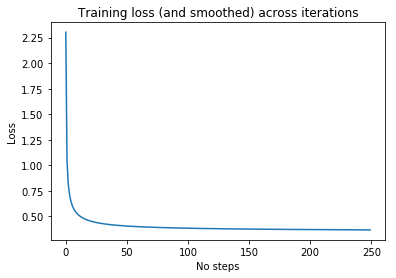

accuracy: 0.9157
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      2761
          1       0.92      0.97      0.95      3151
          2       0.92      0.89      0.91      2796
          3       0.91      0.88      0.90      2856
          4       0.91      0.93      0.92      2730
          5       0.89      0.87      0.88      2525
          6       0.94      0.95      0.94      2751
          7       0.93      0.93      0.93      2917
          8       0.90      0.86      0.88      2730
          9       0.89      0.89      0.89      2783

avg / total       0.92      0.92      0.92     28000



In [9]:
plot_loss_and_accuracy(lreg)

## Logistic regression with Stochastic Gradient Descent

In [10]:
sgd_lreg = LogisticRegression(
  n_iter=250,
  batch_size=1000,
  lmbda=0.001,
  l1_ratio=0.5,
  learning_rate=0.25)

%time sgd_lreg.fit(X_train, y_train)

CPU times: user 4.32 s, sys: 52 ms, total: 4.37 s
Wall time: 2.32 s


Final loss: 0.3994
Final loss, smoothed: 0.3754


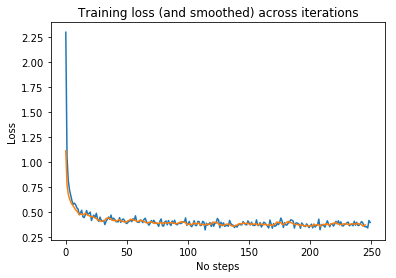

accuracy: 0.9158
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      2761
          1       0.92      0.97      0.95      3151
          2       0.93      0.89      0.91      2796
          3       0.91      0.89      0.90      2856
          4       0.90      0.94      0.92      2730
          5       0.89      0.87      0.88      2525
          6       0.93      0.95      0.94      2751
          7       0.93      0.93      0.93      2917
          8       0.90      0.85      0.88      2730
          9       0.89      0.90      0.89      2783

avg / total       0.92      0.92      0.92     28000



In [11]:
plot_loss_and_accuracy(sgd_lreg, add_smoothing=True)

## Logistic regression with Stochastic Gradient Descent and momentum

Note learning rate is 10x lower and we use 2x less iterations.

In [12]:
sgd_momentum_lreg = LogisticRegression(
  n_iter=125,
  batch_size=1000,
  lmbda=0.001,
  l1_ratio=0.5,
  learning_rate=0.05,
  momentum={'method': 'momentum', 'decay': 0.9})

%time sgd_momentum_lreg.fit(X_train, y_train)

CPU times: user 2.4 s, sys: 28 ms, total: 2.42 s
Wall time: 1.34 s


Final loss: 0.4361
Final loss, smoothed: 0.3942


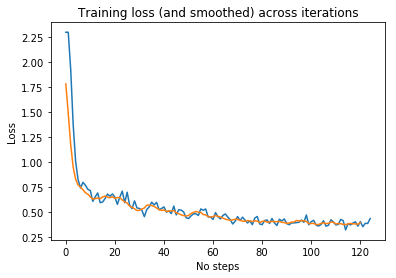

accuracy: 0.9154
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      2761
          1       0.92      0.97      0.95      3151
          2       0.93      0.88      0.90      2796
          3       0.91      0.89      0.90      2856
          4       0.91      0.94      0.92      2730
          5       0.89      0.86      0.88      2525
          6       0.94      0.95      0.95      2751
          7       0.92      0.94      0.93      2917
          8       0.89      0.85      0.87      2730
          9       0.91      0.88      0.89      2783

avg / total       0.92      0.92      0.92     28000



In [13]:
plot_loss_and_accuracy(sgd_momentum_lreg, add_smoothing=True)

## Visualizing weights

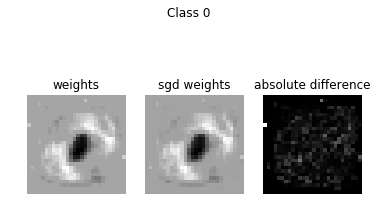

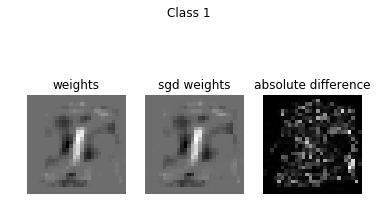

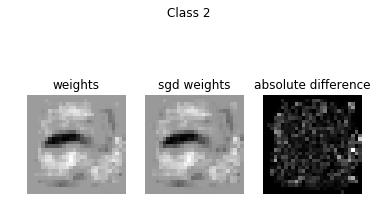

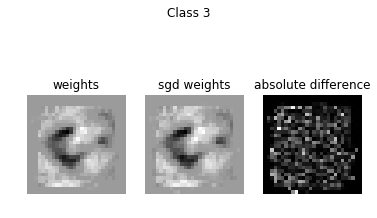

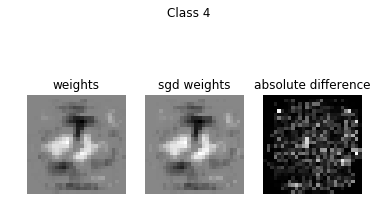

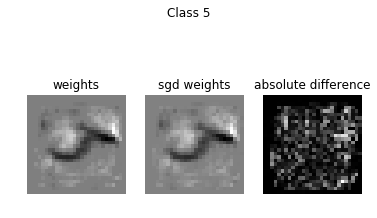

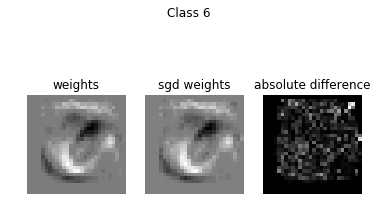

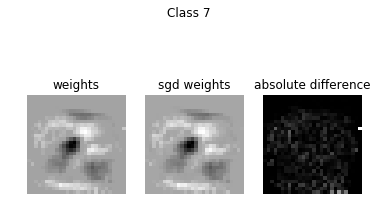

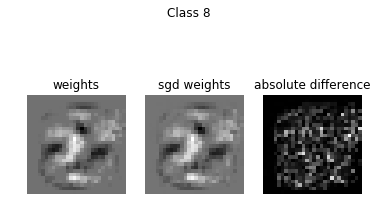

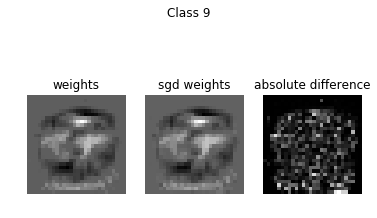

In [14]:
b = lreg.thB.get_value()

for i in range(10):
  digit_weights = lreg.thW.get_value().T[i, :].reshape(28, 28)
  sgd_digit_weights = sgd_lreg.thW.get_value().T[i, :].reshape(28, 28)
  f, ((ax1, ax2, ax3)) = plt.subplots(1, 3)
  f.suptitle('Class {}'.format(i)) 
  
  
  ax1.imshow(digit_weights , cmap='gray')
  ax1.set_title('weights')
  ax1.axis('off') 
  
  ax2.imshow(sgd_digit_weights, cmap='gray')
  ax2.set_title('sgd weights')
  ax2.axis('off') 
  
  ax3.imshow(abs(digit_weights - sgd_digit_weights), cmap='gray')
  ax3.set_title('absolute difference'.format(str(i)))
  ax3.axis('off') 
  plt.show()